# TP Final de Aprendizaje Profundo

### Noelia Melina Qualindi

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html

## Importar Librerías

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.stats import loguniform

# tensorflow
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MSE
from tensorflow.keras.optimizers import Adadelta, Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# sklearn
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, train_test_split

## Dataset

In [3]:
# Utilizaremos solo imagenes de 7 personas con mas de 70 imagenes disponibles.
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.5, download_if_missing=True, color=False)

# Inspeccion de los tamaños
n_samples, height, weight = lfw_people.images.shape

# Datos sin divir en subconjuntos
X = lfw_people.images

# Etiquetas y clases
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
n_features = X.shape[1]

print("Total dataset size:")
print("height, weight: (%d, %d)" % (height, weight))
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes) # cantidad de salidas de la red
print("n_features: %d" % n_features)
# Features: numeros reales, entre 0 y 1
print("Numeros reales entre 0 y 1:", X[0])

Total dataset size:
height, weight: (62, 47)
n_samples: 1288
n_classes: 7
n_features: 62
Numeros reales entre 0 y 1: [[0.9973857  0.9973857  0.99607843 ... 0.26928106 0.23267974 0.20261438]
 [0.9973857  0.99607843 0.99477124 ... 0.275817   0.24052288 0.20915033]
 [0.9882353  0.97647065 0.96732026 ... 0.26928106 0.24052288 0.21830066]
 ...
 [0.3372549  0.2784314  0.20522876 ... 0.4117647  0.39869282 0.37908497]
 [0.30980393 0.2522876  0.19738562 ... 0.39607847 0.39607844 0.37254906]
 [0.28496733 0.24705882 0.19869281 ... 0.38431373 0.3869281  0.3803922 ]]


## Parámetros de entrenamiento y constantes

In [4]:
# Parámetros de entrenamiento
lr = 1.0
epochs = 100
batch_size = 64
np.random.seed(14)
num_augmented_images = 4
augmented_images_to_show = 10

## Funciones para graficar

In [6]:
# Algunas funciones para graficar
def plot_gallery(images, number, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(number):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y, target_names):
    return "%s" % (target_names[y])

def predict_title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)

# Función para mostrar las imágenes aumentadas
def plot_augmented_images(datagen, image, num_augmented_images = num_augmented_images):
    plt.figure(figsize=(8, 5))
    plt.subplot(1, num_augmented_images + 1, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original", size=9)
    plt.axis('off')

    augmented_images = datagen.flow(np.expand_dims(image, axis=0), batch_size=batch_size)
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.45)
    
    for i in range(num_augmented_images):
        augmented_image = augmented_images.next().squeeze()
        plt.subplot(1, num_augmented_images + 1, i + 2)
        plt.imshow(augmented_image, cmap='gray')
        plt.title(f"Augmented {i + 1}", size=8)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

### Visualizar el dataset

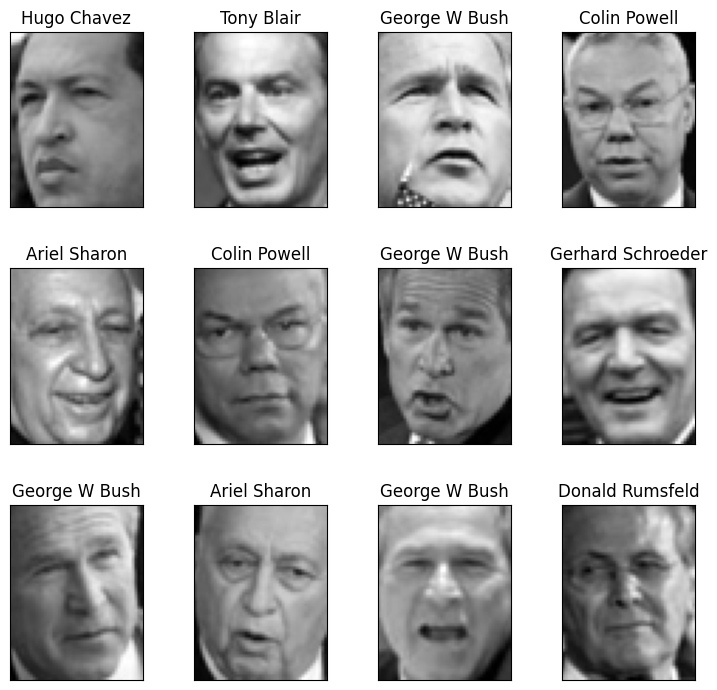

In [7]:
titles = [title(y[i], target_names) for i in range(20)]
# originales
plot_gallery(X, 12, titles, height, weight)

## Grupos de entrenamiento

In [8]:
# Crear los grupos de entrenamiento (80%) y testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print('Training data shape : ', X_train.shape, y_train.shape)
print('Testing data shape : ', X_test.shape, y_test.shape)
n_classes = np.max(np.unique(y_train)) + 1
print("Classes:", n_classes)

Training data shape :  (1030, 62, 47) (1030,)
Testing data shape :  (258, 62, 47) (258,)
Classes: 7


In [9]:
print('Original label:', y_train.shape)

y_train_labels_one_hot = to_categorical(y_train, n_classes)
y_test_labels_one_hot = to_categorical(y_test, n_classes) #one-hot encoding

print('Encoded y_train_labels:', y_train_labels_one_hot.shape)
print('Encoded y_test_labels:', y_test_labels_one_hot.shape)

Original label: (1030,)
Encoded y_train_labels: (1030, 7)
Encoded y_test_labels: (258, 7)


In [10]:
# reshepeo las dimensiones de X_test para que sea compatible con el modelo conv2D utilizando 1 dimension para las imagenes en b & n
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

print("X_train reshaped: ", X_train.shape)
print("X_test reshaped: ", X_test.shape)

X_train reshaped:  (1030, 62, 47, 1)
X_test reshaped:  (258, 62, 47, 1)


## Aumentación de datos

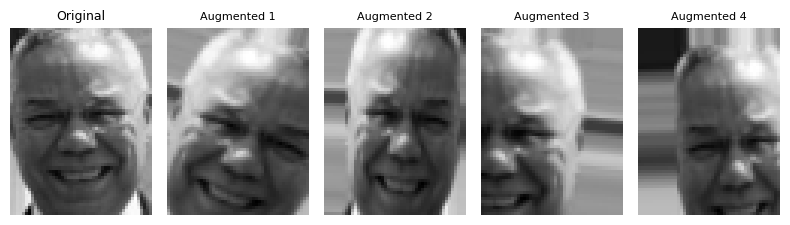

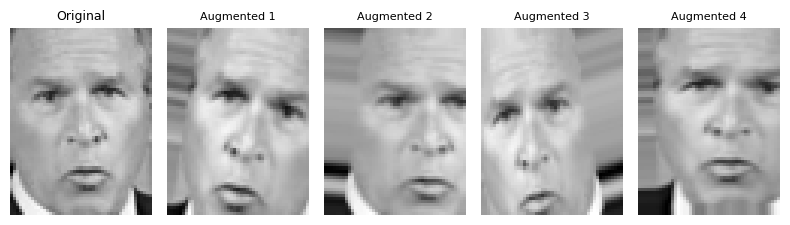

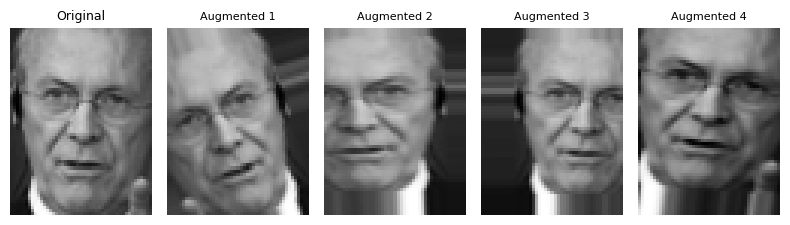

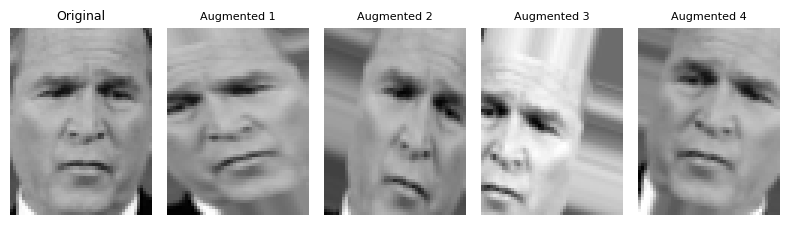

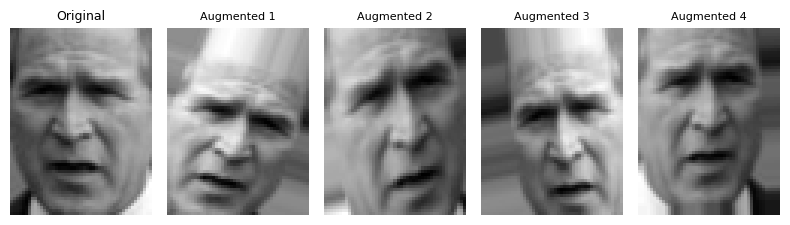

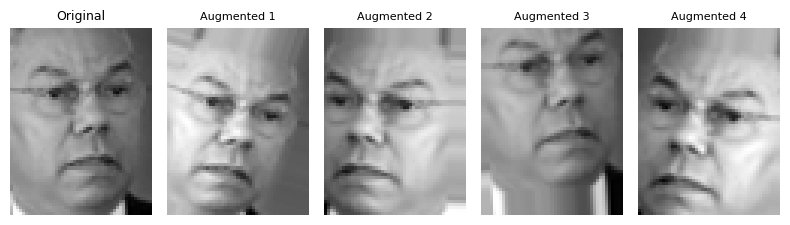

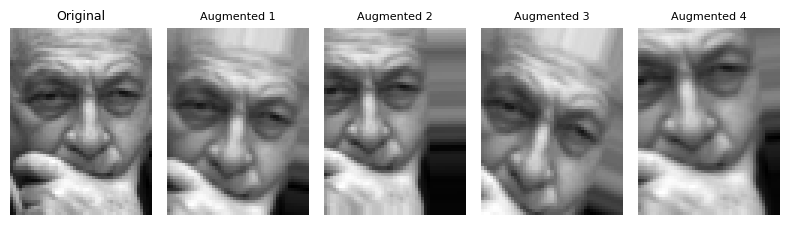

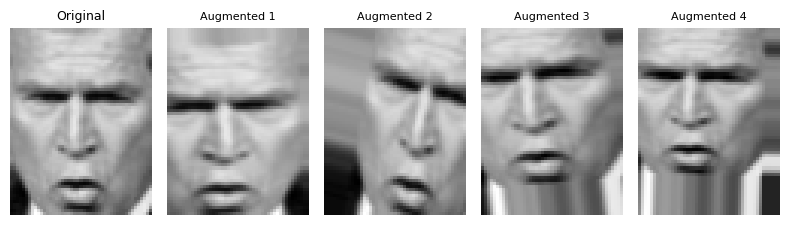

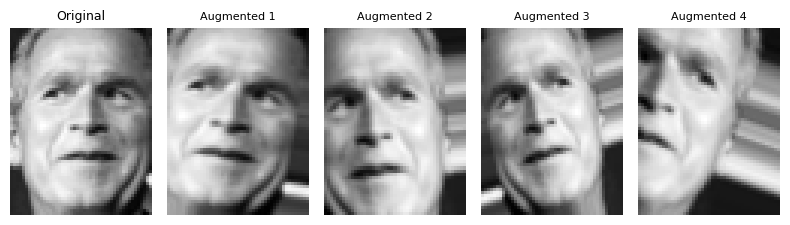

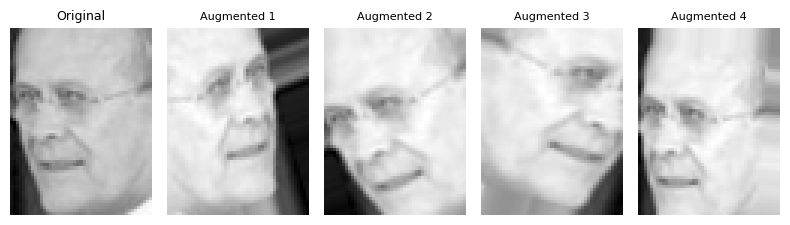

In [11]:
# Data Augmentation - generador de imagenes
datagen = ImageDataGenerator(
    rotation_range=20,      # Rango de rotación en grados
    width_shift_range=0.2,  # Desplazamiento horizontal
    height_shift_range=0.2, # Desplazamiento vertical
    shear_range=0.2,        # Intensidad de deformación
    zoom_range=0.2,         # Rango de zoom
    horizontal_flip=True,   # Voltear horizontalmente
    fill_mode='nearest'     # Modo de llenado para píxeles nuevos
)

# Muestra algunas imágenes aumentadas del conjunto de entrenamiento
for i in range(augmented_images_to_show):
    random_idx = np.random.randint(len(X_train))
    sample_image = X_train[random_idx]
    plot_augmented_images(datagen, sample_image)

datagen.fit(X_train)

## Modelo convolucional

In [12]:
input_layer = Input(shape=X_train.shape[1:])

conv_1 = Conv2D(32, (3, 3), activation='relu') (input_layer) # primer parametro son 32 kernels, cada kernel tiene 3x3
pool_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1) # maxpooling vienen dados por 2 pix x 2 pix, rectangulo de 4 px. Nos quedamos con el pixel de mayor valor.

conv_2 = Conv2D(64, (3, 3), activation='relu') (conv_1) #profundidad de 64 kernels - 64 canales
pool_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)

conv_3 = Conv2D(128, (3, 3), activation='relu') (conv_2) #profundidad de 128 kernels - 128 canales
pool_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3) 

conv_4 = Conv2D(256, (3, 3), activation='relu') (conv_3) #profundidad de 256 kernels - 256 canales
pool_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4) 

dropout_1 = Dropout(0.25) (pool_4)
flatten_1 = Flatten() (dropout_1) #aplasta las dimensiones de la red para ajustarlo a las dimensiones de salida (cntidad de clases)
dense_1 = Dense(100, activation='relu')(flatten_1)
dropout_2 = Dropout(0.25) (dense_1)
output_layer = Dense(n_classes, activation='softmax') (dropout_2)
faces_model = Model(input_layer, output_layer)

### Resumen del modelo

In [13]:
faces_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', 'mse'])
faces_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 62, 47, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 60, 45, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 43, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 41, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 54, 39, 256)       295168    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 27, 19, 256)      0         
 2D)                                                             
                                                             

## Entrenamiento del modelo

In [14]:
# Entrenar el modelo
steps_per_epoch = int(round(X_train.shape[0]/batch_size))
start_time = time.time()

data_generator = datagen.flow(X_train, y_train_labels_one_hot, batch_size=batch_size)

# Entrenar el modelo con data augmentation
faces_train_dropout = faces_model.fit(data_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=epochs, 
                    validation_data=(X_test, y_test_labels_one_hot),
                    workers=5,
                    shuffle=True,
                    verbose=1)

end_time = time.time()
print('\nElapsed Dense Model training time: {:.5f} seconds'.format(end_time-start_time))

Epoch 1/100


2023-07-25 12:16:18.288256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


16/16 [==============================] - 20s 1s/step - loss: 2.0272 - acc: 0.3540 - mse: 0.1195 - val_loss: 1.6508 - val_acc: 0.4612 - val_mse: 0.1073
Epoch 2/100
16/16 [==============================] - 19s 1s/step - loss: 1.7287 - acc: 0.3975 - mse: 0.1113 - val_loss: 1.6089 - val_acc: 0.4612 - val_mse: 0.1050
Epoch 3/100
16/16 [==============================] - 19s 1s/step - loss: 1.7373 - acc: 0.3934 - mse: 0.1118 - val_loss: 1.6107 - val_acc: 0.4612 - val_mse: 0.1047
Epoch 4/100
16/16 [==============================] - 19s 1s/step - loss: 1.7314 - acc: 0.3986 - mse: 0.1117 - val_loss: 1.6199 - val_acc: 0.4612 - val_mse: 0.1054
Epoch 5/100
16/16 [==============================] - 20s 1s/step - loss: 1.7020 - acc: 0.3986 - mse: 0.1096 - val_loss: 1.5624 - val_acc: 0.4612 - val_mse: 0.1015
Epoch 6/100
16/16 [==============================] - 20s 1s/step - loss: 1.6989 - acc: 0.4006 - mse: 0.1096 - val_loss: 1.5764 - val_acc: 0.4612 - val_mse: 0.1024
Epoch 7/100
16/16 [===============

### Guardar el Modelo

In [15]:
faces_model.save('./faces_CNN.h5')

## Visualización de las curvas de aprendizaje

In [16]:
faces_train_dropout.history.keys()

dict_keys(['loss', 'acc', 'mse', 'val_loss', 'val_acc', 'val_mse'])

Text(0.5, 1.0, 'Error Medio Cuadrático')

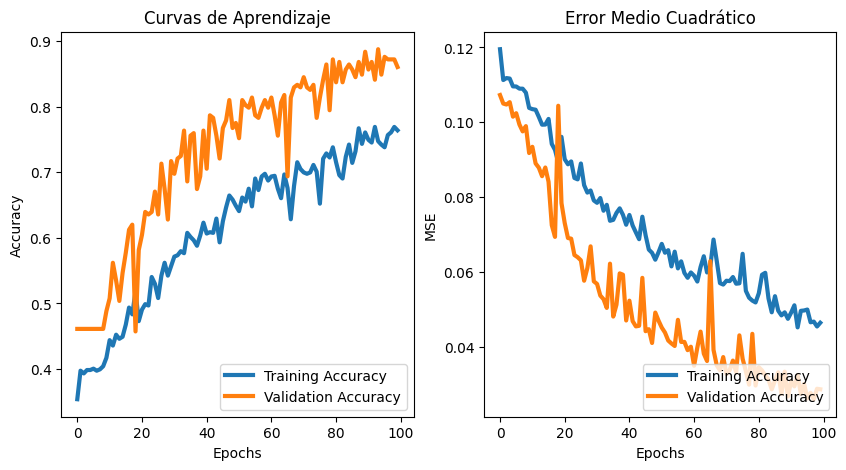

In [18]:
f = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(faces_train_dropout.history['acc'], linewidth=3, label='Training Accuracy')
plt.plot(faces_train_dropout.history['val_acc'], linewidth=3, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Curvas de Aprendizaje')

plt.subplot(1,2,2)
plt.plot(faces_train_dropout.history['mse'], linewidth=3, label='Training Accuracy')
plt.plot(faces_train_dropout.history['val_mse'], linewidth=3, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(loc='lower right')
plt.title('Error Medio Cuadrático')

## Evaluación del modelo

In [19]:
# Evaluación del modelo en el conjunto de prueba
test_eval = faces_model.evaluate(X_test, y_test_labels_one_hot, verbose=1)

print("Pérdida en el conjunto de prueba - Test loss:", test_eval[0])
print("Exactitud en el conjunto de prueba - Test Accuracy:", test_eval[1])

9/9 [==============================] - 1s 135ms/step - loss: 0.4362 - acc: 0.8605 - mse: 0.0286
Pérdida en el conjunto de prueba - Test loss: 0.43621063232421875
Exactitud en el conjunto de prueba - Test Accuracy: 0.8604651093482971


## Predicciones del conjunto de prueba

9/9 [==============================] - 1s 128ms/step


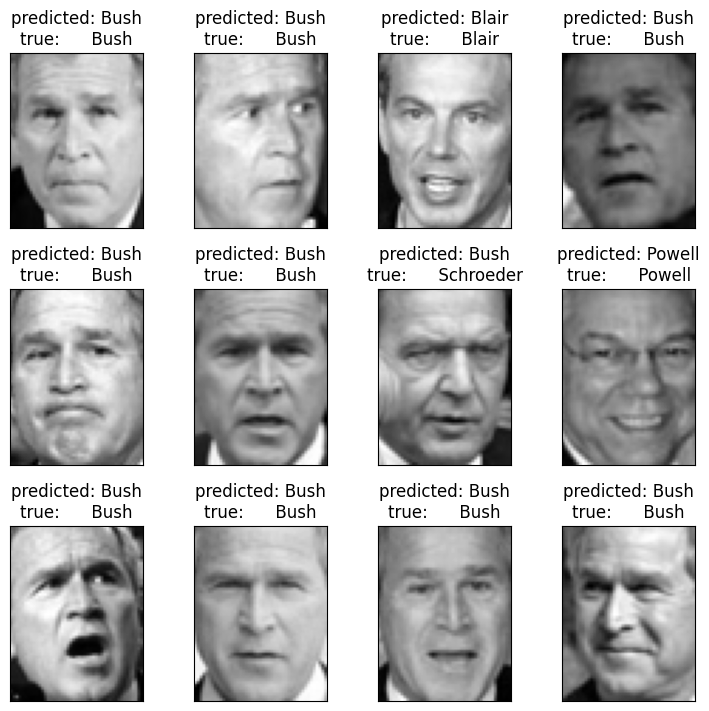

In [20]:
# Predicciones del modelo en el conjunto de prueba
prediction = faces_model.predict(X_test, verbose=1)
predicted_labels = np.argmax(prediction, axis=1)

prediction_titles = [
    predict_title(predicted_labels, y_test, target_names, i) for i in range(predicted_labels.shape[0])
]

plot_gallery(X_test, 12, prediction_titles, height, weight)

## Matríz de Confusión

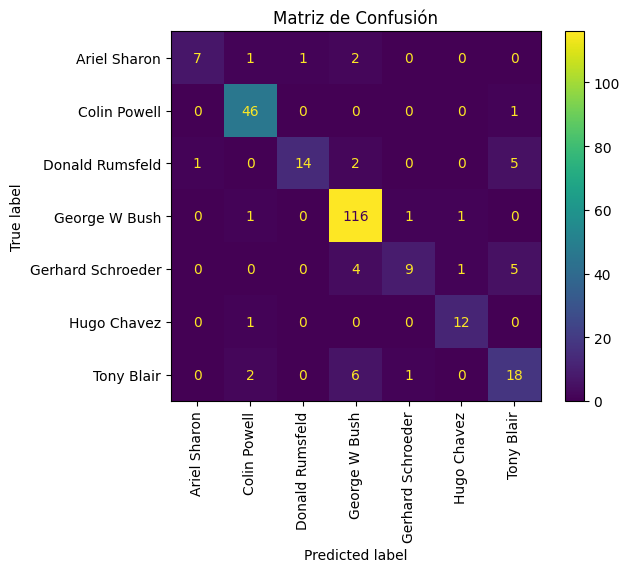

In [21]:
# Matriz de confusión
cm = confusion_matrix(y_test, predicted_labels, labels=np.arange(n_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names) #display_labels=np.arange(n_classes)
disp.plot(cmap='viridis', values_format='d')
plt.xticks(rotation=90)
plt.title('Matriz de Confusión')
plt.show()